# Processamento e Sumarização da Tabela de Itens

## Objetivo
Processar a tabela `tb_itens` reduzindo de 81 para aproximadamente 50 colunas relevantes, criando features derivadas para análise de produtividade.

## Estratégia
1. Filtrar apenas itens presentes na base de merge
2. Remover colunas irrelevantes (paletização, status, referências)
3. Padronizar valores e nomenclaturas
4. Criar features derivadas de complexidade
5. Validar transformações
6. Exportar tabela sumarizada

In [1]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

## Carregamento e Análise Inicial dos Dados

In [2]:
# Carregamento dos dados
df_itens = pd.read_parquet("../../../data/raw/tb_itens.parquet")
df_merge_base = pd.read_parquet("tb_merge_base.parquet")

print(f"Registros em tb_itens: {df_itens.shape[0]:,}")
print(f"Colunas em tb_itens: {df_itens.shape[1]}")
print(f"Registros em df_merge_base: {df_merge_base.shape[0]:,}")
print(f"Itens únicos em df_merge_base: {df_merge_base.CD_ITEM.nunique():,}")

Registros em tb_itens: 70,274
Colunas em tb_itens: 81
Registros em df_merge_base: 1,493,740
Itens únicos em df_merge_base: 7,608


In [3]:
# Filtrar apenas itens relevantes baseado na base de merge
list_itens = list(df_merge_base.CD_ITEM.unique())
df_itens_fil = df_itens[df_itens.CD_ITEM.isin(list_itens)].reset_index(drop=True)

print(f"Registros originais: {df_itens.shape[0]:,}")
print(f"Registros filtrados: {df_itens_fil.shape[0]:,}")
print(f"Redução: {(1 - df_itens_fil.shape[0] / df_itens.shape[0]) * 100:.1f}%")
print(f"Itens únicos filtrados: {df_itens_fil.CD_ITEM.nunique():,}")

Registros originais: 70,274
Registros filtrados: 7,606
Redução: 89.2%
Itens únicos filtrados: 7,606


## Limpeza e Padronização dos Dados

In [4]:
# Análise de estados das facas
print("Estados das facas:")
print(df_itens_fil.TX_ESTADOFT_DETEC.value_counts())
print("\nStatus das facas:")
print(df_itens_fil.TX_STATUSFT.value_counts().head(10))

Estados das facas:
TX_ESTADOFT_DETEC
Ativa         6260
Suspenso      1273
Desativada      64
Amostra          9
Name: count, dtype: Int64

Status das facas:
TX_STATUSFT
Ativa (DETEC)                                                               2911
Suspensa (Vendas) Ativa (DETEC)                                             2160
Desativada (Clichê) Suspensa (Vendas) Ativa (DETEC)                          813
Suspensa (Vendas) Suspensa (DETEC)                                           539
Desativada (Clichê) Suspensa (Vendas) Suspensa (DETEC)                       320
Desativada (Faca) Desativada (Clichê) Suspensa (Vendas) Ativa (DETEC)        304
Suspensa (DETEC)                                                             182
Desativada (Faca) Desativada (Clichê) Suspensa (Vendas) Suspensa (DETEC)     115
Desativada (Faca) Suspensa (Vendas) Ativa (DETEC)                             61
Desativada (DETEC)                                                            47
Name: count, dtype: 

In [5]:
# Remover itens desativados e colunas de status redundantes
df_itens_fil = df_itens_fil[~df_itens_fil.TX_ESTADOFT_DETEC.isin(["Desativada"])]

colunas_remover_status = [
    "TX_ESTADOFT_DETEC",
    "ST_ESTADOFT_DETEC",
    "ST_STATUSFT",
    "TX_STATUSFT",
    "TX_REFERENCIA",
    "CD_REFERENCIA",
]

df_itens_fil.drop(columns=colunas_remover_status, inplace=True)

print(f"Registros após limpeza: {df_itens_fil.shape[0]:,}")
print(f"Colunas após limpeza: {df_itens_fil.shape[1]}")

Registros após limpeza: 7,542
Colunas após limpeza: 75


In [6]:
# Padronizar valores especiais
print("Valores únicos em CD_TIPOFT2:")
print(df_itens_fil.CD_TIPOFT2.value_counts())

# Converter -1 e 2 para 0 e 1 (padronização binária)
df_itens_fil.CD_TIPOFT2.replace(["-1", "2"], ["0", "1"], inplace=True)

print("\nApós padronização:")
print(df_itens_fil.CD_TIPOFT2.value_counts())

Valores únicos em CD_TIPOFT2:
CD_TIPOFT2
-1    7460
2       82
Name: count, dtype: Int64

Após padronização:
CD_TIPOFT2
0    7460
1      82
Name: count, dtype: Int64


/tmp/ipykernel_201218/274049950.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_itens_fil.CD_TIPOFT2.replace(["-1", "2"], ["0", "1"], inplace=True)


## Renomeação e Organização das Colunas

In [7]:
# Renomear colunas para melhor semântica
df_itens_ref = df_itens_fil.rename(
    columns={
        "FL_EXIGELAUDO": "FL_TESTE_EXIGELAUDO",
        "VL_COLUNAMINIMO": "VL_TESTE_COLUNA_MINIMO",
        "VL_COBBINTMAXIMO": "VL_TESTE_COBB_INT_MAX",
        "VL_COMPRESSAO": "VL_TESTE_COMPRESSAO",
        "VL_GRAMATURA": "VL_TESTE_GRAMATURA",
        "CD_ESPELHO": "FL_ESPELHO",
        "CD_FILME": "FL_FILME",
        "CD_TIPOFT2": "FL_CONTROLE_ESPECIAL_IMPRESSAO",
        "VL_LAPINTERNO": "FL_LAP_INTERNO",
        "VL_LAPNOCOMP": "FL_LAP_NO_COMPR",
    }
)

print(f"Colunas renomeadas: {len(df_itens_ref.columns)}")

Colunas renomeadas: 75


In [8]:
# Remover colunas relacionadas a paletização (não relevantes para produtividade)
colunas_paletizacao = [
    "CD_PALETE",
    "FL_PALETIZADO",
    "ID_CLIENTE",
    "QT_PACOTESPORPALETE",
    "QT_UNIDADESPORPALETE",
    "QT_PECASPORPACOTE",
    "QT_PECASPORPALETE",
    "VL_ALTURAPACOTE",
    "VL_ALTURAPALETEFECHADO",
    "VL_COMPPACOTE",
    "VL_COMPPALETEFECHADO",
    "VL_VOLUMEPALETEFECHADOM3",
    "VL_VOLUMEPACOTEFECHADOM3",
    "FL_AMARRADO",
    "TX_COR1",
    "TX_COR2",
    "TX_COR3",
    "TX_COR4",
    "VL_PACOTESALTURA",
    "VL_PACOTESCOMPRIMENTO",
    "VL_PACOTESLARGURA",
    "VL_LARGPACOTE",
    "VL_LARGPALETEFECHADO",
]

# Verificar quais colunas existem antes de remover
colunas_existentes = [col for col in colunas_paletizacao if col in df_itens_ref.columns]
df_itens_ref.drop(columns=colunas_existentes, inplace=True)

print(f"Colunas removidas: {len(colunas_existentes)}")
print(f"Colunas restantes: {df_itens_ref.shape[1]}")

Colunas removidas: 23
Colunas restantes: 52


In [9]:
# Organizar colunas alfabeticamente para melhor visualização
df_itens_ref = df_itens_ref[sorted(df_itens_ref.columns)]

print("Primeiras 10 colunas após organização:")
print(list(df_itens_ref.columns[:50]))

Primeiras 10 colunas após organização:
['CD_FACA', 'CD_FAMILIA', 'CD_ITEM', 'FL_CONTROLE_ESPECIAL_IMPRESSAO', 'FL_ESPELHO', 'FL_FILME', 'FL_LAP_INTERNO', 'FL_LAP_NO_COMPR', 'FL_REFILADO', 'FL_RESINAINTERNA', 'FL_TESTE_EXIGELAUDO', 'QT_ARRANJO', 'QT_NRCORES', 'QT_PROLONGLAP', 'TX_COMPOSICAO', 'TX_PATHFIGURADOLASTRO', 'TX_TIPOABNT', 'VL_ALTURAINTERNA', 'VL_AREABRUTACHAPA', 'VL_AREABRUTAPECA', 'VL_AREABRUTAPECACOMREFILOS', 'VL_AREALIQUIDACHAPA', 'VL_AREALIQUIDAPECA', 'VL_COMPPECA', 'VL_COMPRIMENTO', 'VL_COMPRIMENTOINTERNO', 'VL_CONSUMOCOR1', 'VL_CONSUMOCOR2', 'VL_CONSUMOCOR3', 'VL_CONSUMOCOR4', 'VL_LAP', 'VL_LARGPECA', 'VL_LARGURA', 'VL_LARGURAINTERNA', 'VL_MULTCOMP', 'VL_MULTLARG', 'VL_PESOCAIXA', 'VL_REFILOCOMPRIMENTO', 'VL_REFILOLARGURA', 'VL_REFUGOCLIENTE', 'VL_TESTE_COBB_INT_MAX', 'VL_TESTE_COLUNA_MINIMO', 'VL_TESTE_COMPRESSAO', 'VL_TESTE_GRAMATURA', 'VL_VINCOCOMP1', 'VL_VINCOCOMP2', 'VL_VINCOCOMP3', 'VL_VINCOCOMP4', 'VL_VINCOCOMP5', 'VL_VINCOLARG1']


In [10]:
cols_drop_fim = ["CD_FAMILIA", "TX_PATHFIGURADOLASTRO"]

df_itens_ref.drop(columns=cols_drop_fim, inplace=True)

## Feature Engineering - Transformações e Novas Features

In [11]:
# Criar flag para exigência de peso específico
df_itens_ref["FL_EXIG_PESOCAIXA"] = np.where(df_itens_ref["VL_PESOCAIXA"] > 0, 1, 0)

print("Distribuição de exigência de peso:")
print(df_itens_ref["FL_EXIG_PESOCAIXA"].value_counts())
print(
    f"Percentual com exigência: {df_itens_ref['FL_EXIG_PESOCAIXA'].mean() * 100:.1f}%"
)

Distribuição de exigência de peso:
FL_EXIG_PESOCAIXA
1    6512
0    1030
Name: count, dtype: int64
Percentual com exigência: 86.3%


In [12]:
df_itens_ref["VL_PESOCAIXA"]

0         0.0
1         0.0
2       290.0
3         0.0
4       290.0
        ...  
7601      0.0
7602    278.0
7603    235.0
7604    440.0
7605    154.0
Name: VL_PESOCAIXA, Length: 7542, dtype: float64

In [13]:
# Consolidar consumo total de tinta
colunas_consumo = [
    "VL_CONSUMOCOR1",
    "VL_CONSUMOCOR2",
    "VL_CONSUMOCOR3",
    "VL_CONSUMOCOR4",
]

df_itens_ref["VL_CONSUMO_COR_TOTAL"] = df_itens_ref[colunas_consumo].sum(axis=1)

# Análise da correlação entre consumo total e número de cores
correlacao = df_itens_ref[["VL_CONSUMO_COR_TOTAL", "QT_NRCORES"]].corr().iloc[0, 1]
print(f"Correlação consumo total vs número de cores: {correlacao:.3f}")


Correlação consumo total vs número de cores: 0.440


In [14]:
# Remover colunas individuais de consumo
df_itens_ref.drop(columns=colunas_consumo, inplace=True)

print(f"Itens com consumo > 0: {(df_itens_ref['VL_CONSUMO_COR_TOTAL'] > 0).sum():,}")


Itens com consumo > 0: 6,972


In [15]:
# Padronizar valores especiais (-1 para 0 em flags LAP)
colunas_lap = ["FL_LAP_INTERNO", "FL_LAP_NO_COMPR"]
df_itens_ref[colunas_lap] = df_itens_ref[colunas_lap].replace(-1, 0)

# Padronizar strings vazias
colunas_texto = ["TX_TIPOABNT"]
df_itens_ref[colunas_texto] = df_itens_ref[colunas_texto].replace([" ", ""], "NA")

print("Valores únicos em TX_TIPOABNT após padronização:")
print(df_itens_ref["TX_TIPOABNT"].value_counts())

Valores únicos em TX_TIPOABNT após padronização:
TX_TIPOABNT
CN     3130
18      525
19      476
16      447
17      422
       ... 
6         1
132       1
143       1
144       1
15        1
Name: count, Length: 83, dtype: Int64


## Criação de Features Derivadas

In [16]:
# 1. Contagem de vincos por direção
vincos_comp_cols = [
    "VL_VINCOCOMP1",
    "VL_VINCOCOMP2",
    "VL_VINCOCOMP3",
    "VL_VINCOCOMP4",
    "VL_VINCOCOMP5",
]
vincos_larg_cols = ["VL_VINCOLARG1", "VL_VINCOLARG2", "VL_VINCOLARG3"]

df_itens_ref["QT_VINCOS_COMP"] = (df_itens_ref[vincos_comp_cols] > 0).sum(axis=1)
df_itens_ref["QT_VINCOS_LARG"] = (df_itens_ref[vincos_larg_cols] > 0).sum(axis=1)
df_itens_ref["QT_VINCOS_TOTAL"] = (
    df_itens_ref["QT_VINCOS_COMP"] + df_itens_ref["QT_VINCOS_LARG"]
)

print("Distribuição de vincos:")
print(f"Comprimento - Máximo: {df_itens_ref['QT_VINCOS_COMP'].max()}")
print(f"Largura - Máximo: {df_itens_ref['QT_VINCOS_LARG'].max()}")
print(f"Total - Máximo: {df_itens_ref['QT_VINCOS_TOTAL'].max()}")
print(f"Itens com vincos: {(df_itens_ref['QT_VINCOS_TOTAL'] > 0).sum():,}")

Distribuição de vincos:
Comprimento - Máximo: 5
Largura - Máximo: 3
Total - Máximo: 8
Itens com vincos: 4,159


In [17]:
# 2. Indicadores de LAP (prolongamentos)
df_itens_ref["FL_TEM_LAP"] = (
    (df_itens_ref["VL_LAP"] > 0)
    | (df_itens_ref["QT_PROLONGLAP"] > 0)
    | (df_itens_ref["FL_LAP_INTERNO"] > 0)
    | (df_itens_ref["FL_LAP_NO_COMPR"] > 0)
).astype(int)

df_itens_ref["VL_LAP_TOTAL"] = (
    df_itens_ref[["VL_LAP", "FL_LAP_INTERNO", "FL_LAP_NO_COMPR"]]
    .replace(-1, 0)
    .sum(axis=1)
)

print(f"Itens com LAP: {df_itens_ref['FL_TEM_LAP'].sum():,}")
print(f"Percentual com LAP: {df_itens_ref['FL_TEM_LAP'].mean() * 100:.1f}%")
print(
    f"LAP total médio (itens com LAP): {df_itens_ref[df_itens_ref['VL_LAP_TOTAL'] > 0]['VL_LAP_TOTAL'].mean():.2f}"
)

Itens com LAP: 4,211
Percentual com LAP: 55.8%
LAP total médio (itens com LAP): 31.03


In [18]:
# 3. Score de exigências de qualidade
df_itens_ref["SCORE_QUALIDADE"] = (
    df_itens_ref["FL_TESTE_EXIGELAUDO"].astype(int)
    + (df_itens_ref["VL_TESTE_COLUNA_MINIMO"] > 0).astype(int)
    + (df_itens_ref["VL_TESTE_COBB_INT_MAX"] > 0).astype(int)
    + (df_itens_ref["VL_TESTE_COMPRESSAO"] > 0).astype(int)
    + (df_itens_ref["VL_TESTE_GRAMATURA"] > 0).astype(int)
)

print("Distribuição do Score de Qualidade:")
print(df_itens_ref["SCORE_QUALIDADE"].value_counts().sort_index())

# Análise dos componentes
componentes = {
    "Exige laudo": df_itens_ref["FL_TESTE_EXIGELAUDO"].astype(int).sum(),
    "Teste coluna": (df_itens_ref["VL_TESTE_COLUNA_MINIMO"] > 0).sum(),
    "Teste Cobb": (df_itens_ref["VL_TESTE_COBB_INT_MAX"] > 0).sum(),
    "Teste compressão": (df_itens_ref["VL_TESTE_COMPRESSAO"] > 0).sum(),
    "Teste gramatura": (df_itens_ref["VL_TESTE_GRAMATURA"] > 0).sum(),
}

print("\nComponentes do score:")
for comp, valor in componentes.items():
    pct = valor / len(df_itens_ref) * 100
    print(f"  {comp}: {valor:,} ({pct:.1f}%)")

Distribuição do Score de Qualidade:
SCORE_QUALIDADE
0     363
1     148
2     633
3     690
4    5374
5     334
Name: count, dtype: int64

Componentes do score:
  Exige laudo: 6,524 (86.5%)
  Teste coluna: 7,025 (93.1%)
  Teste Cobb: 6,109 (81.0%)
  Teste compressão: 425 (5.6%)
  Teste gramatura: 6,567 (87.1%)


In [19]:
# 4. Análise do tipo de onda
df_itens_ref["TX_ONDA_TIPO"] = df_itens_ref["TX_COMPOSICAO"].str.extract(
    r"^([A-Z]+\d*)", expand=False
)

df_itens_ref["FL_ONDA_DUPLA"] = (
    df_itens_ref["TX_COMPOSICAO"]
    .str.contains(r"[+\-]", regex=True, na=False)
    .astype(int)
)

print("Top 10 tipos de onda:")
print(df_itens_ref["TX_ONDA_TIPO"].value_counts().head(10))

pct_ondas_duplas = df_itens_ref["FL_ONDA_DUPLA"].mean() * 100
print(f"\nPercentual de ondas duplas: {pct_ondas_duplas:.1f}%")

print("\nExemplos de composições duplas:")
exemplos_duplas = (
    df_itens_ref[df_itens_ref["FL_ONDA_DUPLA"] == 1]["TX_COMPOSICAO"]
    .value_counts()
    .head(5)
)
print(exemplos_duplas)

Top 10 tipos de onda:
TX_ONDA_TIPO
A3     1952
A1     1711
A10    1058
A2      871
A12     421
A15     322
B1      296
B10     208
A4      198
A18     188
Name: count, dtype: Int64

Percentual de ondas duplas: 100.0%

Exemplos de composições duplas:
TX_COMPOSICAO
A3-B     1190
A1-B     1098
A3-C      445
A1-D      437
A10-C     429
Name: count, dtype: Int64


In [20]:
# 5. Score de complexidade total do item
df_itens_ref["SCORE_COMPLEXIDADE"] = (
    df_itens_ref["QT_NRCORES"]
    + df_itens_ref["QT_VINCOS_TOTAL"]
    + df_itens_ref["SCORE_QUALIDADE"]
    + df_itens_ref["FL_TEM_LAP"] * 2
    + (df_itens_ref["FL_CONTROLE_ESPECIAL_IMPRESSAO"] == "1").astype(int) * 2
)/7


In [21]:
print("Estatísticas do Score de Complexidade:")
df_itens_ref[["SCORE_COMPLEXIDADE"]].describe().T


Estatísticas do Score de Complexidade:


,count,mean,std,min,25%,50%,75%,max
SCORE_COMPLEXIDADE,7542.0,1.525931,0.72441,0.0,0.714286,1.857143,2.142857,2.857143


In [22]:
print("\nDistribuição da complexidade:")
print(df_itens_ref[["SCORE_COMPLEXIDADE"]].value_counts().sort_index().head(15))


Distribuição da complexidade:
SCORE_COMPLEXIDADE
0.000000                14
0.142857                25
0.285714                59
0.428571               105
0.571429               397
0.714286              1628
0.857143               584
1.000000               389
1.142857               144
1.285714                27
1.428571                43
1.571429                98
1.714286               171
1.857143               330
2.000000               489
Name: count, dtype: int64


In [23]:
# 6. Razão dimensional (alongamento da chapa)
df_itens_ref["RAZAO_COMP_LARG"] = (
    df_itens_ref["VL_COMPRIMENTO"] / df_itens_ref["VL_LARGURA"]
).replace([np.inf, -np.inf], np.nan)

print("Estatísticas da Razão Comprimento/Largura:")
(df_itens_ref[["RAZAO_COMP_LARG"]].describe().T)


Estatísticas da Razão Comprimento/Largura:


,count,mean,std,min,25%,50%,75%,max
RAZAO_COMP_LARG,7542.0,2.543666,0.817788,0.2672,1.986188,2.51149,3.035014,6.300613


In [24]:
# Identificar valores extremos
q99 = df_itens_ref["RAZAO_COMP_LARG"].quantile(0.99)
q01 = df_itens_ref["RAZAO_COMP_LARG"].quantile(0.01)
print(f"\nValores extremos (P1-P99): {q01:.2f} - {q99:.2f}")



Valores extremos (P1-P99): 0.75 - 4.22


In [25]:
print("\nFeatures derivadas criadas com sucesso!")
print(f"Total de colunas: {df_itens_ref.shape[1]}")


Features derivadas criadas com sucesso!
Total de colunas: 58


In [26]:
df_itens_ref.head()

,CD_FACA,CD_ITEM,FL_CONTROLE_ESPECIAL_IMPRESSAO,FL_ESPELHO,FL_FILME,FL_LAP_INTERNO,FL_LAP_NO_COMPR,FL_REFILADO,FL_RESINAINTERNA,FL_TESTE_EXIGELAUDO,QT_ARRANJO,QT_NRCORES,QT_PROLONGLAP,TX_COMPOSICAO,TX_TIPOABNT,VL_ALTURAINTERNA,VL_AREABRUTACHAPA,VL_AREABRUTAPECA,VL_AREABRUTAPECACOMREFILOS,VL_AREALIQUIDACHAPA,VL_AREALIQUIDAPECA,VL_COMPPECA,VL_COMPRIMENTO,VL_COMPRIMENTOINTERNO,VL_LAP,VL_LARGPECA,VL_LARGURA,VL_LARGURAINTERNA,VL_MULTCOMP,VL_MULTLARG,VL_PESOCAIXA,VL_REFILOCOMPRIMENTO,VL_REFILOLARGURA,VL_REFUGOCLIENTE,VL_TESTE_COBB_INT_MAX,VL_TESTE_COLUNA_MINIMO,VL_TESTE_COMPRESSAO,VL_TESTE_GRAMATURA,VL_VINCOCOMP1,VL_VINCOCOMP2,VL_VINCOCOMP3,VL_VINCOCOMP4,VL_VINCOCOMP5,VL_VINCOLARG1,VL_VINCOLARG2,VL_VINCOLARG3,FL_EXIG_PESOCAIXA,VL_CONSUMO_COR_TOTAL,QT_VINCOS_COMP,QT_VINCOS_LARG,QT_VINCOS_TOTAL,FL_TEM_LAP,VL_LAP_TOTAL,SCORE_QUALIDADE,TX_ONDA_TIPO,FL_ONDA_DUPLA,SCORE_COMPLEXIDADE,RAZAO_COMP_LARG
0,-1,120000,0,0,0,0.0,0.0,1,0,0,1.0,0.0,0.0,A3-B,CH,0.0,0.720000,0.720000,0.720000,0.720000,0.720000,1200.0,1200.0,1200.0,0.0,600.0,600.0,600.0,1.0,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0,0,0,0.0,0,A3,1,0.000000,2.000000
1,-1,130000,0,0,0,0.0,0.0,1,0,0,1.0,0.0,0.0,A4-DC,152,0.0,0.336000,0.336000,0.336000,0.336000,0.336000,1400.0,1400.0,1400.0,0.0,240.0,240.0,240.0,1.0,1.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,120.0,0.0,0,0.0,0,2,2,0,0.0,0,A4,1,0.285714,5.833333
2,-1,141270,0,1,1,1.0,0.0,1,0,1,1.0,1.0,0.0,A12-C,CN,290.0,0.514892,0.514892,0.514892,0.514892,0.503012,994.0,994.0,260.0,30.0,518.0,518.0,215.0,1.0,1.0,290.0,0.0,0.0,2.30728,30.0,8.0,0.0,577.0,30.0,219.0,264.0,219.0,262.0,110.0,298.0,110.0,1,234.0,5,3,8,1,31.0,4,A12,1,2.142857,1.918919
3,-1,141520,0,0,0,1.0,0.0,1,0,0,1.0,3.0,50.0,A2-DC,CN,400.0,1.572210,1.572210,1.572210,1.572210,1.546738,1941.0,1941.0,550.0,40.0,810.0,810.0,390.0,1.0,1.0,0.0,0.0,0.0,1.62014,0.0,0.0,0.0,0.0,40.0,396.0,556.0,396.0,553.0,199.0,412.0,199.0,0,1075.0,5,3,8,1,41.0,0,A2,1,1.857143,2.396296
4,FAZER,184040,1,1,1,1.0,0.0,1,0,0,1.0,2.0,0.0,B3S-B,MCNRt,257.0,0.670306,0.670306,0.670306,0.670306,0.651336,1651.0,1651.0,488.0,30.0,406.0,406.0,318.0,1.0,1.0,290.0,0.0,0.0,2.83000,0.0,5.5,0.0,446.0,30.0,321.0,491.0,321.0,488.0,146.0,260.0,0.0,1,2622.0,5,2,7,1,31.0,2,B3,1,2.142857,4.066502


In [27]:
df_itens_ref.columns

Index(['CD_FACA', 'CD_ITEM', 'FL_CONTROLE_ESPECIAL_IMPRESSAO', 'FL_ESPELHO',
       'FL_FILME', 'FL_LAP_INTERNO', 'FL_LAP_NO_COMPR', 'FL_REFILADO',
       'FL_RESINAINTERNA', 'FL_TESTE_EXIGELAUDO', 'QT_ARRANJO', 'QT_NRCORES',
       'QT_PROLONGLAP', 'TX_COMPOSICAO', 'TX_TIPOABNT', 'VL_ALTURAINTERNA',
       'VL_AREABRUTACHAPA', 'VL_AREABRUTAPECA', 'VL_AREABRUTAPECACOMREFILOS',
       'VL_AREALIQUIDACHAPA', 'VL_AREALIQUIDAPECA', 'VL_COMPPECA',
       'VL_COMPRIMENTO', 'VL_COMPRIMENTOINTERNO', 'VL_LAP', 'VL_LARGPECA',
       'VL_LARGURA', 'VL_LARGURAINTERNA', 'VL_MULTCOMP', 'VL_MULTLARG',
       'VL_PESOCAIXA', 'VL_REFILOCOMPRIMENTO', 'VL_REFILOLARGURA',
       'VL_REFUGOCLIENTE', 'VL_TESTE_COBB_INT_MAX', 'VL_TESTE_COLUNA_MINIMO',
       'VL_TESTE_COMPRESSAO', 'VL_TESTE_GRAMATURA', 'VL_VINCOCOMP1',
       'VL_VINCOCOMP2', 'VL_VINCOCOMP3', 'VL_VINCOCOMP4', 'VL_VINCOCOMP5',
       'VL_VINCOLARG1', 'VL_VINCOLARG2', 'VL_VINCOLARG3', 'FL_EXIG_PESOCAIXA',
       'VL_CONSUMO_COR_TOTAL', 'QT_VIN

## Validação e Análise das Features

In [28]:
# Análise consolidada das features derivadas
features_derivadas = [
    "VL_CONSUMO_COR_TOTAL",
    "QT_VINCOS_TOTAL",
    "FL_TEM_LAP",
    "VL_LAP_TOTAL",
    "SCORE_QUALIDADE",
    "FL_ONDA_DUPLA",
    "SCORE_COMPLEXIDADE",
    "RAZAO_COMP_LARG",
]

print("Resumo das Features Derivadas:")

for feature in features_derivadas:
    if feature in df_itens_ref.columns:
        serie = df_itens_ref[feature]
        print(f"\n{feature}:")
        print(
            f"  Não-nulos: {serie.notna().sum():,} ({serie.notna().mean() * 100:.1f}%)"
        )

        if serie.dtype in ["int64", "float64"]:
            print(f"  Min/Max: {serie.min():.2f} / {serie.max():.2f}")
            print(f"  Média: {serie.mean():.2f}")
            print(f"  Mediana: {serie.median():.2f}")
            if feature.startswith("FL_") or feature.startswith("QT_"):
                print(f"  Valores únicos: {sorted(serie.unique())[:10]}")
        else:
            print(f"  Valores únicos: {serie.nunique()}")

Resumo das Features Derivadas:

VL_CONSUMO_COR_TOTAL:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.00 / 15469.00
  Média: 965.21
  Mediana: 499.00

QT_VINCOS_TOTAL:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.00 / 8.00
  Média: 4.35
  Mediana: 7.00
  Valores únicos: [np.int64(0), np.int64(2), np.int64(3), np.int64(5), np.int64(7), np.int64(8)]

FL_TEM_LAP:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.00 / 1.00
  Média: 0.56
  Mediana: 1.00
  Valores únicos: [np.int64(0), np.int64(1)]

VL_LAP_TOTAL:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.00 / 42.00
  Média: 17.32
  Mediana: 31.00

SCORE_QUALIDADE:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.00 / 5.00
  Média: 3.53
  Mediana: 4.00

FL_ONDA_DUPLA:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 1.00 / 1.00
  Média: 1.00
  Mediana: 1.00
  Valores únicos: [np.int64(1)]

SCORE_COMPLEXIDADE:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.00 / 2.86
  Média: 1.53
  Mediana: 1.86

RAZAO_COMP_LARG:
  Não-nulos: 7,542 (100.0%)
  Min/Max: 0.27 / 6.30
  Média: 2.54
  Mediana:

In [29]:
df_itens_ref.rename(columns={"TX_COMPOSICAO":"CD_COMPOSICAO"},inplace=True)

In [30]:
# Top 10 itens mais complexos para validação
colunas_analise = [
    "CD_ITEM",
    "QT_NRCORES",
    "CD_COMPOSICAO",
    "QT_VINCOS_TOTAL",
    "SCORE_QUALIDADE",
    "FL_TEM_LAP",
    "TX_TIPOABNT",
    "TX_ONDA_TIPO",
    "SCORE_COMPLEXIDADE",
]

top_complexos = df_itens_ref.nlargest(10, "SCORE_COMPLEXIDADE")[colunas_analise]

print("Top 10 Itens Mais Complexos:")
print("=" * 80)
print(top_complexos.to_string(index=False))

Top 10 Itens Mais Complexos:
CD_ITEM  QT_NRCORES CD_COMPOSICAO  QT_VINCOS_TOTAL  SCORE_QUALIDADE  FL_TEM_LAP TX_TIPOABNT TX_ONDA_TIPO  SCORE_COMPLEXIDADE
 857870         4.0          A3-B                8                4           1          CN           A3            2.857143
 491810         4.0         A3S-B                7                4           1       MCNRt           A3            2.714286
 674510         4.0         B3S-B                7                4           1       MCNRt           B3            2.714286
 678390         4.0         A3-DC                8                5           1          CN           A3            2.714286
 681780         4.0          A1-B                8                3           1          CN           A1            2.714286
 717250         3.0          B1-B                8                4           1          CN           B1            2.714286
 718850         3.0          A3-B                8                4           1          CN     

In [34]:
# Matriz de correlação entre features numéricas derivadas
features_numericas = [
    "QT_NRCORES",
    "VL_CONSUMO_COR_TOTAL",
    "QT_VINCOS_TOTAL",
    "VL_LAP_TOTAL",
    "SCORE_QUALIDADE",
    "SCORE_COMPLEXIDADE",
    "RAZAO_COMP_LARG",
]
import seaborn as sns
import matplotlib.pyplot as plt


In [36]:
df_itens_ref[features_numericas].describe()


,QT_NRCORES,VL_CONSUMO_COR_TOTAL,QT_VINCOS_TOTAL,VL_LAP_TOTAL,SCORE_QUALIDADE,SCORE_COMPLEXIDADE,RAZAO_COMP_LARG
count,7542.000000,7542.000000,7542.000000,7542.000000,7542.000000,7542.000000,7542.000000
mean,1.664545,965.214134,4.345001,17.324185,3.533545,1.525931,2.543666
std,0.965751,1448.875192,3.929567,15.549717,1.095797,0.724410,0.817788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.267200
25%,1.000000,175.000000,0.000000,0.000000,4.000000,0.714286,1.986188
50%,1.000000,499.000000,7.000000,31.000000,4.000000,1.857143,2.511490
75%,2.000000,1085.000000,8.000000,31.000000,4.000000,2.142857,3.035014
max,4.000000,15469.000000,8.000000,42.000000,5.000000,2.857143,6.300613


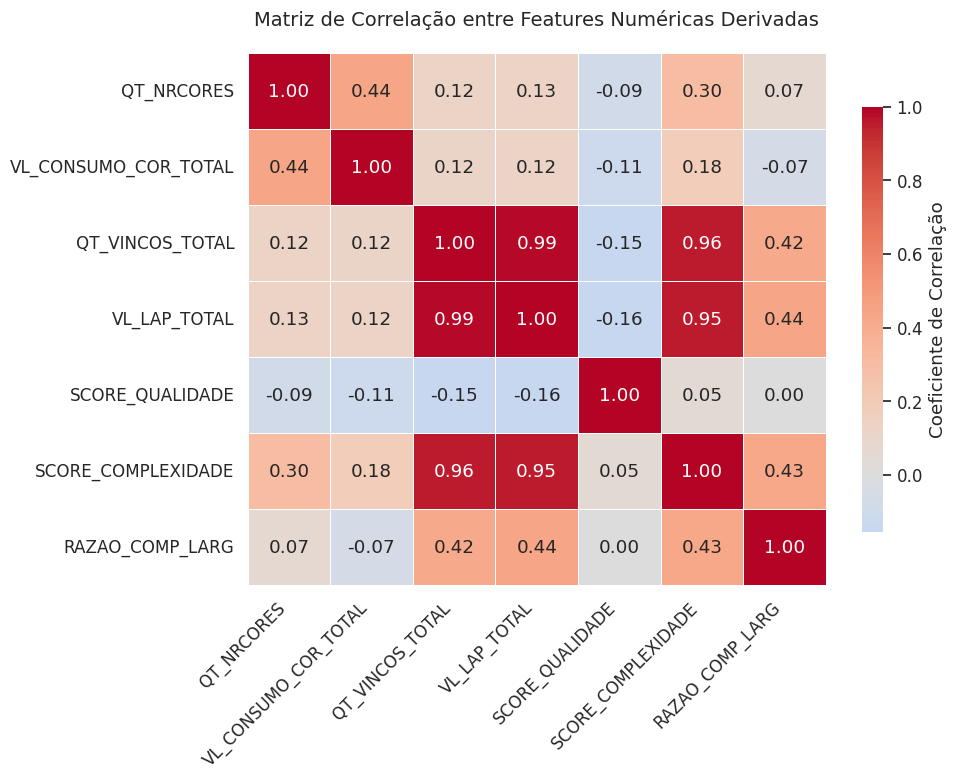

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

features_numericas = [
    "QT_NRCORES",
    "VL_CONSUMO_COR_TOTAL",
    "QT_VINCOS_TOTAL",
    "VL_LAP_TOTAL",
    "SCORE_QUALIDADE",
    "SCORE_COMPLEXIDADE",
    "RAZAO_COMP_LARG",
]

correlacoes = df_itens_ref[features_numericas].corr()

sns.set_theme(style="white", font_scale=1.1)

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(
    correlacoes,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Coeficiente de Correlação"},
)


plt.title(
    "Matriz de Correlação entre Features Numéricas Derivadas", fontsize=14, pad=20
)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [38]:
# Identificar correlações altas (> 0.7)
print("\nCorrelações Altas (> 0.7):")
for i in range(len(correlacoes.columns)):
    for j in range(i + 1, len(correlacoes.columns)):
        corr_val = correlacoes.iloc[i, j]
        if abs(corr_val) > 0.7:
            col1, col2 = correlacoes.columns[i], correlacoes.columns[j]
            print(f"  {col1} vs {col2}: {corr_val:.3f}")



Correlações Altas (> 0.7):
  QT_VINCOS_TOTAL vs VL_LAP_TOTAL: 0.988
  QT_VINCOS_TOTAL vs SCORE_COMPLEXIDADE: 0.958
  VL_LAP_TOTAL vs SCORE_COMPLEXIDADE: 0.951


## Resumo Final e Exportação

In [27]:
# Resumo final da transformação
print("Resumo Final da Transformação")
print("=" * 80)

print(f"Tabela original: {df_itens.shape}")
print(f"Tabela filtrada: {df_itens_fil.shape}")
print(f"Tabela final: {df_itens_ref.shape}")

reducao_colunas = (1 - df_itens_ref.shape[1] / df_itens.shape[1]) * 100
print(f"\nRedução de colunas: {df_itens.shape[1]} → {df_itens_ref.shape[1]}")
print(f"Percentual de redução: {reducao_colunas:.1f}%")

# Informações de memória
memoria_original = df_itens_fil.memory_usage(deep=True).sum() / 1024**2
memoria_final = df_itens_ref.memory_usage(deep=True).sum() / 1024**2
economia_memoria = (1 - memoria_final / memoria_original) * 100

print(f"\nMemória original: {memoria_original:.2f} MB")
print(f"Memória final: {memoria_final:.2f} MB")
print(f"Economia de memória: {economia_memoria:.1f}%")

Resumo Final da Transformação
Tabela original: (70274, 81)
Tabela filtrada: (7606, 81)
Tabela final: (7542, 60)

Redução de colunas: 81 → 60
Percentual de redução: 25.9%

Memória original: 13.38 MB
Memória final: 7.60 MB
Economia de memória: 43.2%


In [39]:
# Categorização das colunas finais
categorias = {
    "Identificadores": [
        col for col in df_itens_ref.columns if col.startswith(("CD_", "ID_"))
    ],
    "Dimensões": [
        col
        for col in df_itens_ref.columns
        if any(x in col for x in ["ALTURA", "LARGURA", "COMPRIMENTO", "AREA"])
    ],
    "Flags/Booleanos": [col for col in df_itens_ref.columns if col.startswith("FL_")],
    "Valores/Medidas": [col for col in df_itens_ref.columns if col.startswith("VL_")],
    "Quantidades": [col for col in df_itens_ref.columns if col.startswith("QT_")],
    "Textos": [col for col in df_itens_ref.columns if col.startswith("TX_")],
    "Scores/Features": [
        col for col in df_itens_ref.columns if col.startswith(("SCORE_", "RAZAO_"))
    ],
}

print(f"\nColunas Finais por Categoria ({len(df_itens_ref.columns)} total):")
print("-" * 80)

for categoria, colunas in categorias.items():
    if colunas:
        print(f"\n{categoria} ({len(colunas)}):")
        for i, col in enumerate(sorted(colunas), 1):
            print(f"  {i:2d}. {col}")

# Verificar se há colunas não categorizadas
todas_categorizadas = set()
for colunas in categorias.values():
    todas_categorizadas.update(colunas)

nao_categorizadas = set(df_itens_ref.columns) - todas_categorizadas
if nao_categorizadas:
    print(f"\nColunas não categorizadas ({len(nao_categorizadas)}):")
    for col in sorted(nao_categorizadas):
        print(f"  - {col}")


Colunas Finais por Categoria (58 total):
--------------------------------------------------------------------------------

Identificadores (3):
   1. CD_COMPOSICAO
   2. CD_FACA
   3. CD_ITEM

Dimensões (12):
   1. VL_ALTURAINTERNA
   2. VL_AREABRUTACHAPA
   3. VL_AREABRUTAPECA
   4. VL_AREABRUTAPECACOMREFILOS
   5. VL_AREALIQUIDACHAPA
   6. VL_AREALIQUIDAPECA
   7. VL_COMPRIMENTO
   8. VL_COMPRIMENTOINTERNO
   9. VL_LARGURA
  10. VL_LARGURAINTERNA
  11. VL_REFILOCOMPRIMENTO
  12. VL_REFILOLARGURA

Flags/Booleanos (11):
   1. FL_CONTROLE_ESPECIAL_IMPRESSAO
   2. FL_ESPELHO
   3. FL_EXIG_PESOCAIXA
   4. FL_FILME
   5. FL_LAP_INTERNO
   6. FL_LAP_NO_COMPR
   7. FL_ONDA_DUPLA
   8. FL_REFILADO
   9. FL_RESINAINTERNA
  10. FL_TEM_LAP
  11. FL_TESTE_EXIGELAUDO

Valores/Medidas (33):
   1. VL_ALTURAINTERNA
   2. VL_AREABRUTACHAPA
   3. VL_AREABRUTAPECA
   4. VL_AREABRUTAPECACOMREFILOS
   5. VL_AREALIQUIDACHAPA
   6. VL_AREALIQUIDAPECA
   7. VL_COMPPECA
   8. VL_COMPRIMENTO
   9. VL_COMPRIME

In [29]:
# Verificação final de qualidade dos dados
print("Verificação Final de Qualidade:")
print("=" * 80)

# Valores nulos por coluna
nulos = df_itens_ref.isnull().sum()
nulos_pct = (nulos / len(df_itens_ref) * 100).round(2)
colunas_com_nulos = nulos[nulos > 0].sort_values(ascending=False)

if len(colunas_com_nulos) > 0:
    print(f"\nColunas com valores nulos ({len(colunas_com_nulos)}):")
    for col in colunas_com_nulos.index[:10]:  # Top 10
        print(f"  {col}: {nulos[col]:,} ({nulos_pct[col]:.1f}%)")
else:
    print("\nNenhuma coluna com valores nulos encontrada.")

# Duplicatas
duplicatas = df_itens_ref.duplicated().sum()
print(f"\nRegistros duplicados: {duplicatas:,}")

# Itens únicos
itens_unicos = df_itens_ref["CD_ITEM"].nunique()
print(f"Itens únicos (CD_ITEM): {itens_unicos:,}")
print(f"Total de registros: {len(df_itens_ref):,}")
print(f"Razão item/registro: {itens_unicos / len(df_itens_ref):.3f}")

Verificação Final de Qualidade:

Nenhuma coluna com valores nulos encontrada.

Registros duplicados: 0
Itens únicos (CD_ITEM): 7,542
Total de registros: 7,542
Razão item/registro: 1.000


In [43]:
import os
output_path = "../../../data/ml/tb_itens_sumarizado.parquet"
df_itens_ref.to_parquet(output_path, index=False)

print(f"\nTabela sumarizada salva em: {output_path}")
print(f"Tamanho do arquivo: {os.path.getsize(output_path) / 1024**2:.2f} MB")


# Salvar também uma amostra em CSV para inspeção
# amostra_path = "tb_itens_sumarizado_amostra.csv"
# df_itens_ref.sample(min(1000, len(df_itens_ref))).to_csv(amostra_path, index=False)
# print(f"Amostra salva em: {amostra_path}")


Tabela sumarizada salva em: ../../../data/ml/tb_itens_sumarizado.parquet
Tamanho do arquivo: 0.67 MB


In [42]:
# df_itens_ref.to_csv("../../../data/refined/tb_itens.parquet")

## Documentação das Features Derivadas

### Features Criadas

#### 1. VL_CONSUMO_COR_TOTAL
- **Descrição**: Soma do consumo das 4 cores individuais (VL_CONSUMOCOR1-4)
- **Tipo**: Numérico contínuo
- **Uso**: Proxy de complexidade de impressão
- **Interpretação**: Valores maiores indicam maior uso de tinta e complexidade

#### 2. QT_VINCOS_COMP / QT_VINCOS_LARG / QT_VINCOS_TOTAL
- **Descrição**: Contagem de vincos por direção
  - Comprimento: 0-5 vincos possíveis
  - Largura: 0-3 vincos possíveis
  - Total: Soma de ambas as direções
- **Tipo**: Numérico discreto
- **Uso**: Indicador de complexidade de dobra
- **Interpretação**: Mais vincos = maior tempo de setup e produção

#### 3. FL_TEM_LAP / VL_LAP_TOTAL
- **Descrição**: 
  - FL_TEM_LAP: Indicador binário de presença de prolongamentos
  - VL_LAP_TOTAL: Soma total dos prolongamentos em mm
- **Tipo**: Binário / Numérico contínuo
- **Uso**: LAP aumenta complexidade de corte e colagem
- **Interpretação**: Presença de LAP indica processo mais complexo

#### 4. SCORE_QUALIDADE
- **Descrição**: Score 0-5 baseado em exigências de qualidade
- **Componentes**:
  - FL_TESTE_EXIGELAUDO (1 ponto)
  - VL_TESTE_COLUNA_MINIMO > 0 (1 ponto)
  - VL_TESTE_COBB_INT_MAX > 0 (1 ponto)
  - VL_TESTE_COMPRESSAO > 0 (1 ponto)
  - VL_TESTE_GRAMATURA > 0 (1 ponto)
- **Tipo**: Numérico discreto (0-5)
- **Uso**: Maior score indica mais controles de qualidade necessários

#### 5. TX_ONDA_TIPO / FL_ONDA_DUPLA
- **Descrição**:
  - TX_ONDA_TIPO: Extração do prefixo da composição (ex: "A1", "B2", "K5")
  - FL_ONDA_DUPLA: Identificação de ondas duplas (contém + ou -)
- **Tipo**: Categórico / Binário
- **Uso**: Ondas duplas são mais complexas de produzir
- **Interpretação**: Diferentes tipos de onda têm características produtivas distintas

#### 6. SCORE_COMPLEXIDADE
- **Descrição**: Score combinado de complexidade total do item
- **Fórmula**: 
  ```
  QT_NRCORES (peso 1) +
  QT_VINCOS_TOTAL (peso 1) +
  SCORE_QUALIDADE (peso 1) +
  FL_TEM_LAP (peso 2) +
  FL_CONTROLE_ESPECIAL_IMPRESSAO == "1" (peso 2)
  ```
- **Tipo**: Numérico discreto
- **Uso**: Métrica única para ranking de complexidade de itens
- **Interpretação**: Maior score = item mais complexo de produzir

#### 7. RAZAO_COMP_LARG
- **Descrição**: Razão entre comprimento e largura da chapa
- **Fórmula**: VL_COMPRIMENTO / VL_LARGURA
- **Tipo**: Numérico contínuo
- **Uso**: Indica alongamento da chapa
- **Interpretação**: Valores extremos podem impactar produtividade

#### 8. FL_EXIG_PESOCAIXA
- **Descrição**: Indicador de exigência de peso específico
- **Fórmula**: VL_PESOCAIXA > 0
- **Tipo**: Binário
- **Uso**: Identifica itens com controle de peso obrigatório

### Uso Recomendado

#### Para Modelagem Preditiva
- Todas as features derivadas são candidatas a preditores
- SCORE_COMPLEXIDADE pode ser usado como target alternativo
- Features categóricas (TX_ONDA_TIPO, TX_TIPOABNT) precisam de encoding

#### Para Segmentação e Análise
- SCORE_COMPLEXIDADE: Classificar itens em grupos de complexidade
- QT_VINCOS_TOTAL: Segmentar por necessidade de vincos
- FL_TEM_LAP: Separar itens com/sem prolongamentos
- SCORE_QUALIDADE: Agrupar por exigências de qualidade

#### Para Merge com Outras Tabelas
- Usar CD_ITEM como chave primária
- Tabela otimizada para join com tb_merge_base
- Estrutura compatível com análises de produtividade

### Considerações Técnicas

#### Tratamento de Valores Especiais
- Valores -1 convertidos para 0 em flags LAP
- Strings vazias padronizadas para "NA"
- Divisões por zero tratadas como NaN

#### Correlações Importantes
- VL_CONSUMO_COR_TOTAL vs QT_NRCORES: Correlação esperada alta
- SCORE_COMPLEXIDADE incorpora múltiplas dimensões
- Features derivadas podem ter correlações por construção

#### Validação Contínua
- Monitorar distribuições das features derivadas
- Verificar consistência com regras de negócio
- Validar correlações esperadas entre features relacionadas

In [ ]:
# # Adicionar import necessário no início
# import os

# # Sumário final para log
# print("\n" + "=" * 80)
# print("PROCESSAMENTO CONCLUÍDO COM SUCESSO")
# print("=" * 80)
# print(f"Data/Hora: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}")
# print(f"Registros processados: {len(df_itens_ref):,}")
# print(
#     f"Features criadas: {len([col for col in df_itens_ref.columns if any(col.startswith(x) for x in ['SCORE_', 'QT_VINCOS', 'FL_TEM_', 'VL_LAP_TOTAL', 'RAZAO_', 'TX_ONDA', 'FL_ONDA', 'VL_CONSUMO_COR_TOTAL', 'FL_EXIG_'])])}"
# )
# print(f"Arquivo de saída: {output_path}")
# print("\nTabela pronta para merge e análises subsequentes.")


PROCESSAMENTO CONCLUÍDO COM SUCESSO
Data/Hora: 2025-11-11 22:50:20
Registros processados: 7,542
Features criadas: 12
Arquivo de saída: tb_itens_sumarizado.parquet

Tabela pronta para merge e análises subsequentes.
